<a href="https://colab.research.google.com/github/BryPhysic/System-Ham/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT LIBRARIES

In [ ]:
import tensorflow as tf
import seaborn as sns
import PIL as pil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix
from typing import Any, Dict
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Sequential
from sklearn.metrics import roc_curve, roc_auc_score, auc
from torch.utils.data import DataLoader
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import roc_curve, auc
from typing import Any, List, Optional, Tuple, Union
from sklearn.metrics import confusion_matrix

## IMPORT DATA - SET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = np.load('/content/drive/MyDrive/DATA - SET/Copia de Copia de brain_tumor.npz')


## FUNCTIONS

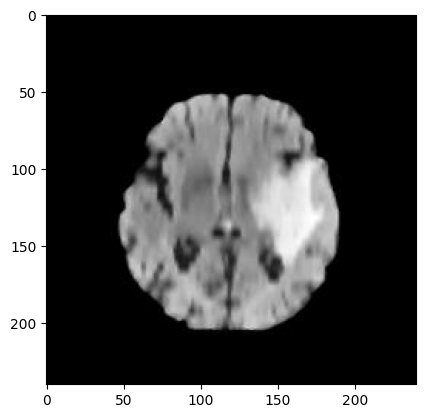

In [ ]:
plt.imshow(dataset['data'][2], cmap='gray', vmax=255, vmin=0)
plt.show()

In [ ]:
def plots_acc(history: Dict[str, Any], title: str = 'Model') -> None:
    """
    Plots training and validation accuracy, as well as training and validation loss.
    Parameters:
    - history (Dict[str, Any]): Dictionary containing training history.
    - title (str): Title for the plot. Default is 'Model'.
    """
    histo = history
    acc = histo.history['accuracy']
    val_acc = histo.history['val_accuracy']
    loss = histo.history['loss']
    val_loss = histo.history['val_loss']

    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.suptitle(title)
    plt.show()

In [ ]:
def plots(history: Dict[str, Any]) -> None:
    """
    Plots training history using a DataFrame.

    Parameters:
    - history (Dict[str, Any]): Dictionary containing training history.
    """
    histo = history
    hist = pd.DataFrame(histo.history)
    hist.plot(xlabel='Epoch', style=['r--', 'r--.', 'b--', 'b-*'])
    plt.show()

## EXPERIMENTAL DATA - SET

In [ ]:
X = dataset['data']
y = dataset['classes']

In [ ]:

class DatSplit:
    def __init__(self, X: List, y: List):
        self.X = X
        self.y = y

    def split(self, test_size: float = 0.15, val_size: float = 0.17, random_state: int = 42) -> Tuple[List, List, List, List, List, List]:

        # Split into training and testing sets
        X_train, X_test, y_train, y_test = tts(self.X, self.y, test_size=test_size, random_state=random_state)
        print(f'Total Data: {len(self.X)}')
        print(f'Test set: {len(X_test)}')
        print(f'TrainVal set: {len(X_train)}')


        val_test_size = val_size / (1 - test_size)# Adjust the size of the validation set


        X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=val_test_size, random_state=random_state)
        print(f'Val set: {len(X_val)}')
        print(f'Train set: {len(X_train)}')


        return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
splitter = DatSplit(X, y)
X_train, X_val, X_test, y_train, y_val, y_test = splitter.split(test_size=0.15, val_size=0.15)

Total Data: 3762
Test set: 565
TrainVal set: 3197
Val set: 565
Train set: 2632


In [ ]:
train_dst = tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_dst = tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_dst = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
batch_size = 32
train_dataset = train_dst.shuffle(buffer_size = len(train_dst)).batch(batch_size)
val_dataset = val_dst.batch(batch_size)
test_dataset = test_dst.batch(batch_size)

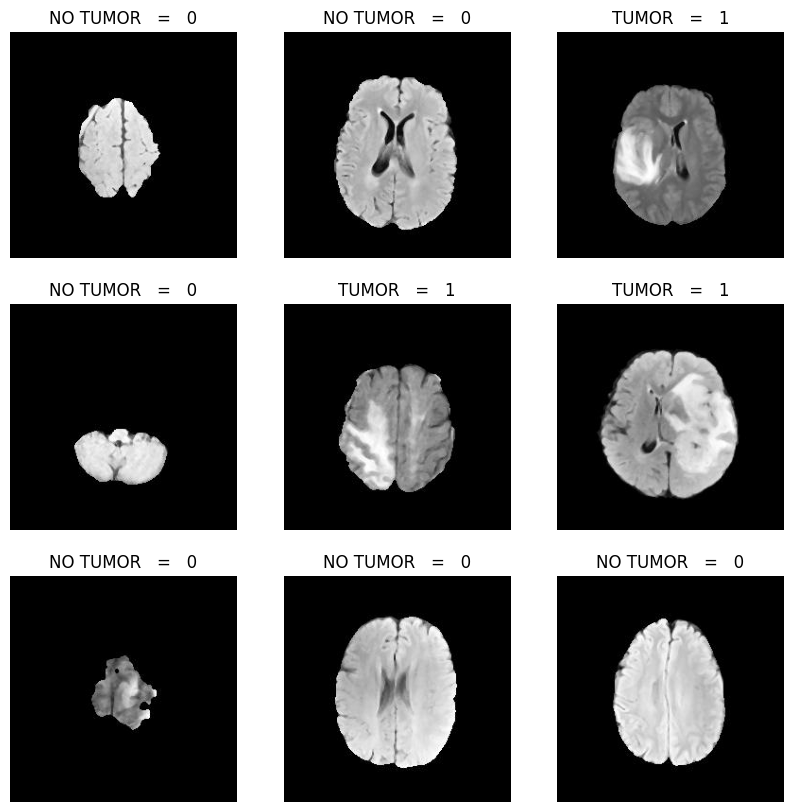

In [ ]:
class_names = ['NO TUMOR', 'TUMOR']
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        label_name = (class_names[labels[i].numpy()])
        label_number = (labels[i].numpy())
        plt.title(f'{label_name}   =   {label_number}')

        plt.axis('off')

In [ ]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    img=images
    lab=labels
    print(labels.shape)

(32, 240, 240, 1)
(32,)


## NEURONAL NETWORK

### FIRST MODEL


In [ ]:
model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(240, 240, 1)),
  layers.Conv2D(10, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(20, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(100, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(120, activation='relu'),
  layers.Dense(20, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(1,activation='sigmoid')

])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 240, 240, 1)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 240, 240, 10)      100       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 120, 120, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 120, 120, 20)      1820      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 60, 60, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 60, 60, 100)     

In [ ]:
binary_loss1 = tf.keras.losses.BinaryCrossentropy(
      from_logits=False,
      label_smoothing=0.1,
      axis=-1,
)
opt_sgd1 = tf.keras.optimizers.experimental.SGD(
                                                  learning_rate=0.001,
                                                  momentum=0.0,
                                                  nesterov=False,
                                                  weight_decay=0.003,
                                                  name='SGD')
model.compile(optimizer=opt_sgd1 ,
      loss = binary_loss1,
      metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/MODELO1', save_best_only=True)

def scheduler(start=10):
    return lambda epoch, lr: lr if epoch < start else lr * tf.math.exp(-0.01)

start_value = 10
learning_rate_scheduler = LearningRateScheduler(scheduler(start=start_value))

list_callbacks = [early_stopping, model_checkpoint, learning_rate_scheduler]

In [ ]:
epochs=100
history = model1.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=list_callbacks
                    )

Epoch 1/100
83/83 [==============================] - 7s 65ms/step - loss: 0.5163 - accuracy: 0.7477 - val_loss: 0.4436 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 2/100
83/83 [==============================] - 5s 55ms/step - loss: 0.4086 - accuracy: 0.8260 - val_loss: 0.3713 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - 6s 75ms/step - loss: 0.3507 - accuracy: 0.8454 - val_loss: 0.3122 - val_accuracy: 0.8478 - lr: 0.0010
Epoch 4/100
83/83 [==============================] - 6s 73ms/step - loss: 0.2561 - accuracy: 0.8936 - val_loss: 0.2631 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 5/100
83/83 [==============================] - 5s 56ms/step - loss: 0.1989 - accuracy: 0.9172 - val_loss: 0.2408 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/100
83/83 [==============================] - 3s 34ms/step - loss: 0.1884 - accuracy: 0.9233 - val_loss: 0.2435 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 7/100
83/83 [==============================] - 5s 59ms/step - lo

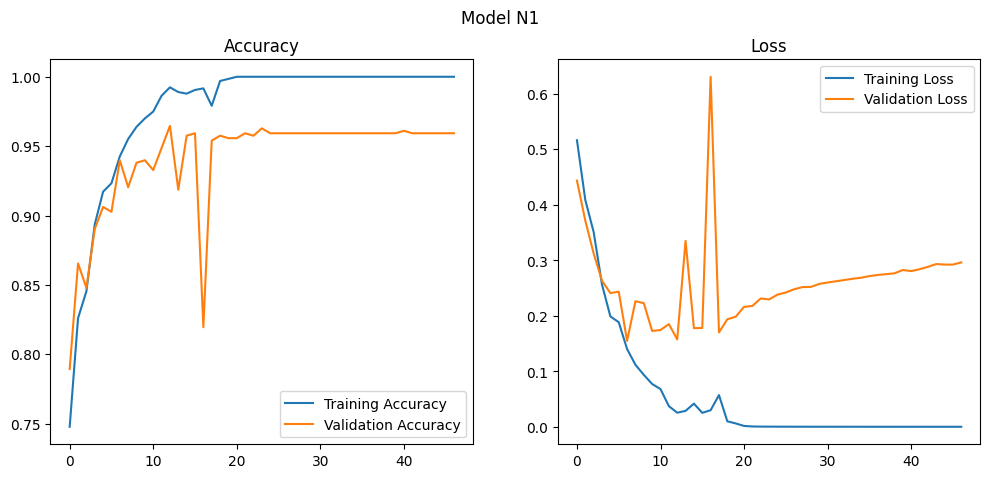

In [ ]:
plots_acc(history, title='Model N1')

### SECOND MODEL


In [ ]:
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(240, 240, 1)),
  layers.Conv2D(10, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(20, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(30, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(40, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(80, activation='relu'),
  layers.Dense(40, activation='relu'),
  layers.Dense(20, activation='relu'),
  layers.Dense(1,activation='sigmoid')

])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 240, 240, 1)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 240, 240, 10)      100       
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 120, 120, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 120, 120, 20)      1820      
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 60, 60, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 60, 60, 30)      

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/MODELO2', save_best_only=True)
def scheduler(start=10):
    return lambda epoch, lr: lr if epoch < start else lr * tf.math.exp(-0.01)

start_value = 10
learning_rate_scheduler = LearningRateScheduler(scheduler(start=start_value))
list_callbacks = [early_stopping, model_checkpoint, learning_rate_scheduler]

In [ ]:
epochs=100
history2 = model2.fit(
  train_dataset,
  validation_data=val_dataset,
  callbacks=list_callbacks,
  epochs=epochs)

Epoch 1/100
83/83 [==============================] - 7s 47ms/step - loss: 0.5270 - accuracy: 0.7470 - val_loss: 0.4160 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 2/100
83/83 [==============================] - 4s 43ms/step - loss: 0.3973 - accuracy: 0.8275 - val_loss: 0.2953 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - 4s 49ms/step - loss: 0.2968 - accuracy: 0.8803 - val_loss: 0.2326 - val_accuracy: 0.9097 - lr: 0.0010
Epoch 4/100
83/83 [==============================] - 5s 56ms/step - loss: 0.2917 - accuracy: 0.8796 - val_loss: 0.2124 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 5/100
83/83 [==============================] - 2s 29ms/step - loss: 0.2477 - accuracy: 0.9024 - val_loss: 0.2491 - val_accuracy: 0.9044 - lr: 0.0010
Epoch 6/100
83/83 [==============================] - 3s 42ms/step - loss: 0.2029 - accuracy: 0.9198 - val_loss: 0.1816 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 7/100
83/83 [==============================] - 2s 29ms/step - lo

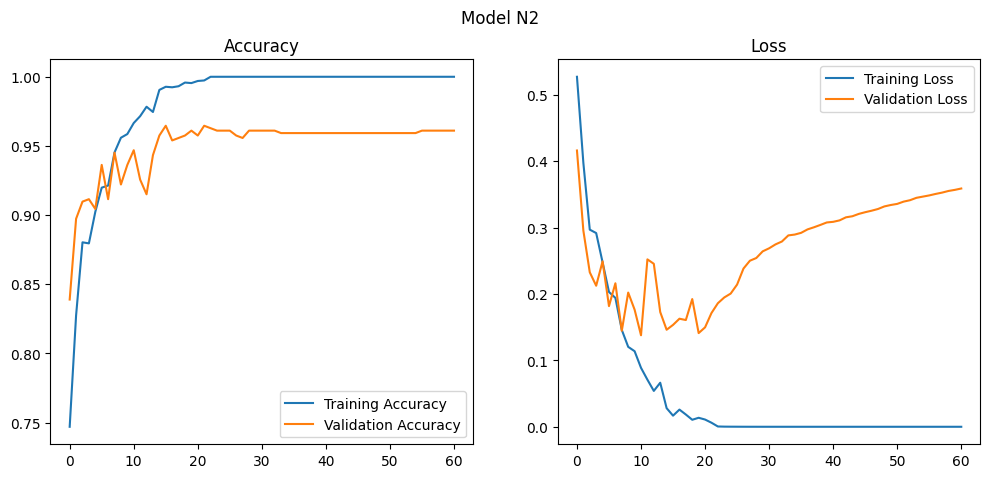

In [ ]:
plots_acc(history2, title='Model N2')

### THIRD MODEL

In [ ]:
img_height = 240
img_width = 240
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal',
                          input_shape=(img_height,
                                       img_width,
                                       1)),
        layers.RandomFlip('vertical',
                          input_shape=(img_height,
                                       img_width,
                                       1)),
        layers.RandomRotation(0.2),
    ]
)

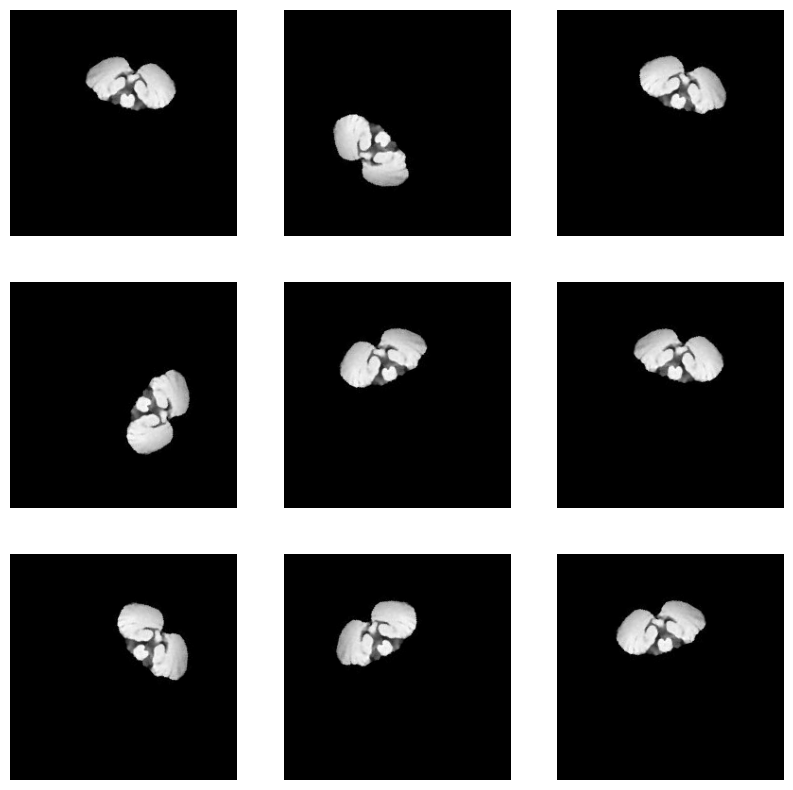

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    num_images = images.shape[0]
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'), cmap='gray')
        plt.axis('off')
plt.show()

In [ ]:
model3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(240, 240, 1)),

  layers.Conv2D(15, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(25, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(35, 3, padding='same', activation='relu'),

  layers.Conv2D(35, 3, padding='same', activation='relu'),

  layers.Conv2D(35, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(300, activation='relu'),
  layers.Dense(200, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(100, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),

  layers.Dense(1,activation='sigmoid')
])

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 240, 240, 15)      150       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 120, 120, 15)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 120, 120, 25)      3400      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 60, 60, 25)        0         
 ng2D)                                                

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
model_checkpoint = ModelCheckpoint('//content/gdrive/MyDrive/ModelsBrain/modelo3D_a.h5', save_best_only=True)

def scheduler(start=10):
    return lambda epoch, lr: lr if epoch < start else lr * tf.math.exp(-0.01)

start_value = 10
learning_rate_scheduler = LearningRateScheduler(scheduler(start=start_value))
list_callbacks = [early_stopping, model_checkpoint, learning_rate_scheduler]

In [ ]:
epochs=100
history3 = model3.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=list_callbacks
)

Epoch 1/100
83/83 [==============================] - 13s 62ms/step - loss: 0.6077 - accuracy: 0.6744 - val_loss: 0.4173 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 2/100
83/83 [==============================] - 4s 45ms/step - loss: 0.4420 - accuracy: 0.8081 - val_loss: 0.3403 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - 4s 46ms/step - loss: 0.4025 - accuracy: 0.8298 - val_loss: 0.3780 - val_accuracy: 0.8088 - lr: 0.0010
Epoch 4/100
83/83 [==============================] - 4s 45ms/step - loss: 0.3990 - accuracy: 0.8267 - val_loss: 0.3968 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 5/100
83/83 [==============================] - 4s 43ms/step - loss: 0.3757 - accuracy: 0.8389 - val_loss: 0.3570 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 6/100
83/83 [==============================] - 4s 50ms/step - loss: 0.3811 - accuracy: 0.8343 - val_loss: 0.3160 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 7/100
83/83 [==============================] - 4s 46ms/step - l

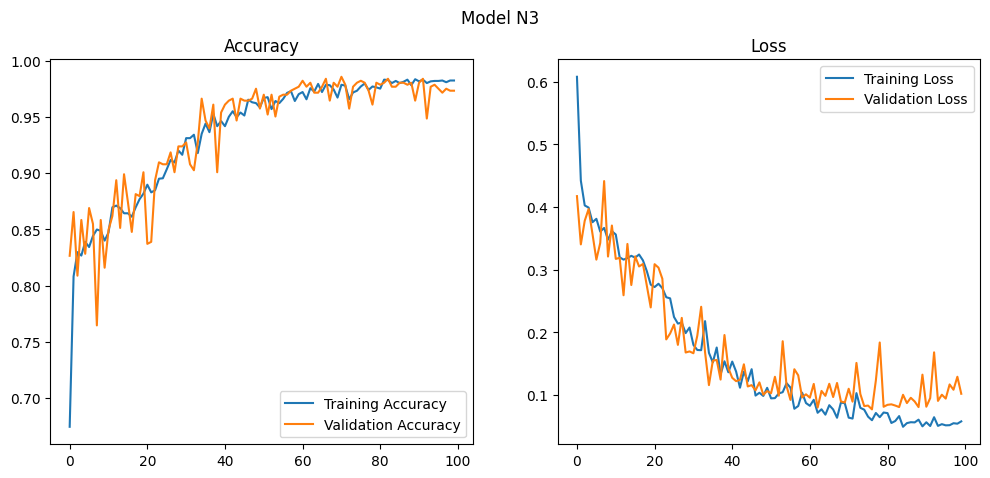

In [ ]:
plots_acc(history3, title='Model N3')

### FOURTH MODEL

In [ ]:

class MyModel(Model):
    def __init__(self, neuroA, neuroB, neuroC, img_height, img_width, dropout_rate=0.3, l1=0.01, l2=0.01):
        super(MyModel, self).__init__()

        self.data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomFlip('vertical'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2, 0.2),
            layers.RandomContrast(0.2),
        ])

        self.rescaling = layers.Rescaling(1./255)

        self.conv1 = layers.Conv2D(15, 3, padding='same', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(25, 3, padding='same', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(35, 3, padding='same', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))
        self.bn3 = layers.BatchNormalization()

        self.maxpool = layers.MaxPooling2D()
        self.flatten = layers.Flatten()

        self.dense1 = layers.Dense(130, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))
        self.dense2 = layers.Dense(20, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))
        self.dense3 = layers.Dense(10, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))
        self.dense4 = layers.Dense(neuroA, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))
        self.dense5 = layers.Dense(neuroB, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2))

        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.data_augmentation(inputs)
        x = self.rescaling(x)

        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)
        x = self.maxpool(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)

        return self.output_layer(x)

#Size of input images and model parameters
img_height = 240
img_width = 240
neuroA = 128
neuroB = 64
neuroC = 32


model4 = MyModel(neuroA, neuroB, neuroC, img_height, img_width)
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])


model4.build(input_shape=(None, img_height, img_width, 1))


model4.summary()


Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           multiple                  150       
                                                                 
 batch_normalization (Batch  multiple                  60        
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           multiple                  3400      
                                                                 
 batch_normalization_1 (Bat  multiple                  100       
 chNormalization)                                       

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/MODELOSFINALES/MODELO3', save_best_only=True)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
learning_rate_scheduler = LearningRateScheduler(scheduler)
list_callbacks=[early_stopping, model_checkpoint, learning_rate_scheduler]

In [ ]:
epochs=125
history4 = model4.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=list_callbacks
)

Epoch 1/125
83/83 [==============================] - 18s 112ms/step - loss: 43.5235 - accuracy: 0.6193 - val_loss: 11.3688 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 2/125
83/83 [==============================] - 8s 91ms/step - loss: 8.2086 - accuracy: 0.7717 - val_loss: 6.5395 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 3/125
83/83 [==============================] - 8s 94ms/step - loss: 5.7888 - accuracy: 0.7789 - val_loss: 5.8697 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 4/125
83/83 [==============================] - 8s 99ms/step - loss: 5.4507 - accuracy: 0.8005 - val_loss: 5.8318 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 5/125
83/83 [==============================] - 8s 92ms/step - loss: 5.3249 - accuracy: 0.8009 - val_loss: 5.7693 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 6/125
83/83 [==============================] - 5s 54ms/step - loss: 5.2295 - accuracy: 0.8127 - val_loss: 5.7915 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 7/125
83/83 [==============================] - 7s 86ms/step 

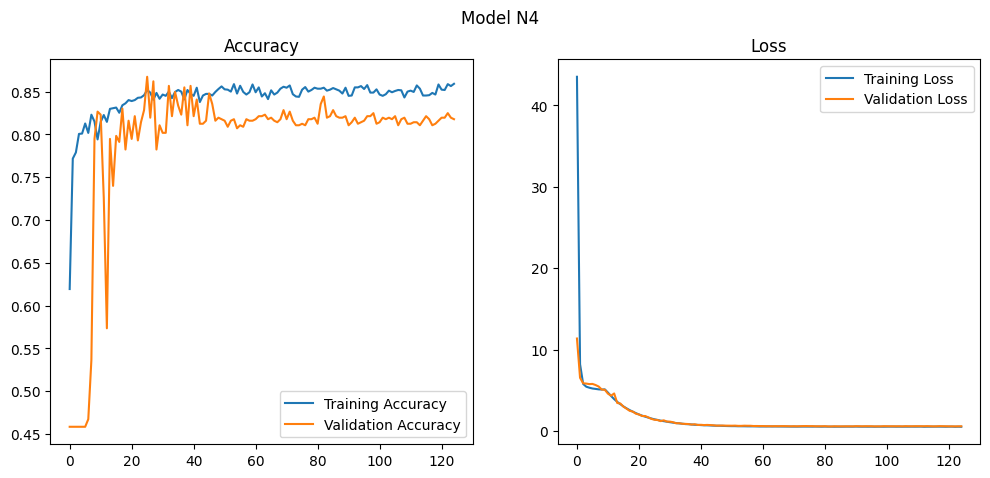

In [ ]:
plots_acc(history4, title='Model N4')

### FIFTH MODEL

In [ ]:
class MyModell(Model):
    def __init__(self, img_height, img_width):
        super(MyModell, self).__init__()

        self.img_height = img_height
        self.img_width = img_width

        self.data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 1)),
            layers.RandomFlip('vertical'),
            layers.RandomZoom(0.2, 0.2),  # Scale change
            layers.RandomContrast(0.2),   # Brightness adjustment
        ])


        self.rescaling = layers.Rescaling(1./255)


        self.conv1 = layers.Conv2D(15, 3, padding='same', activation='relu')
        self.maxpool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(25, 3, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPooling2D()
        self.conv3 = layers.Conv2D(35, 3, padding='same', activation='relu')
        self.maxpool3 = layers.MaxPooling2D()

        # Flattening and dense layers
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(40, activation='relu')
        self.dense2 = layers.Dense(30, activation='relu')
        self.dense3 = layers.Dense(20, activation='relu')


        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.data_augmentation(inputs, training=training)
        x = self.rescaling(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.output_layer(x)

    def build(self, input_shape):
        # Initialize layers with input shape
        input_layer = layers.Input(shape=input_shape[1:])
        self.call(input_layer)
        super(MyModell, self).build(input_shape)

img_height = 240
img_width = 240


model5 = MyModell(img_height, img_width)
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])

# Build the model with desired input shape
model5.build(input_shape=(None, img_height, img_width, 1))


model5.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Save the best model in TensorFlow SavedModel format
model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/MODELOSFINALES/MODELO1', save_best_only=True, save_format='tf')

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learning_rate_scheduler = LearningRateScheduler(scheduler)

list_callbacks = [early_stopping, model_checkpoint, learning_rate_scheduler]

epochs = 120
history5 = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=list_callbacks,
    epochs=epochs
)

Mounted at /content/drive
Model: "my_modell"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 240, 240, 15)      150       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 120, 120, 15)      0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 120, 120, 25)      3400      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 60, 60, 25)        0         
 ng2D)                         

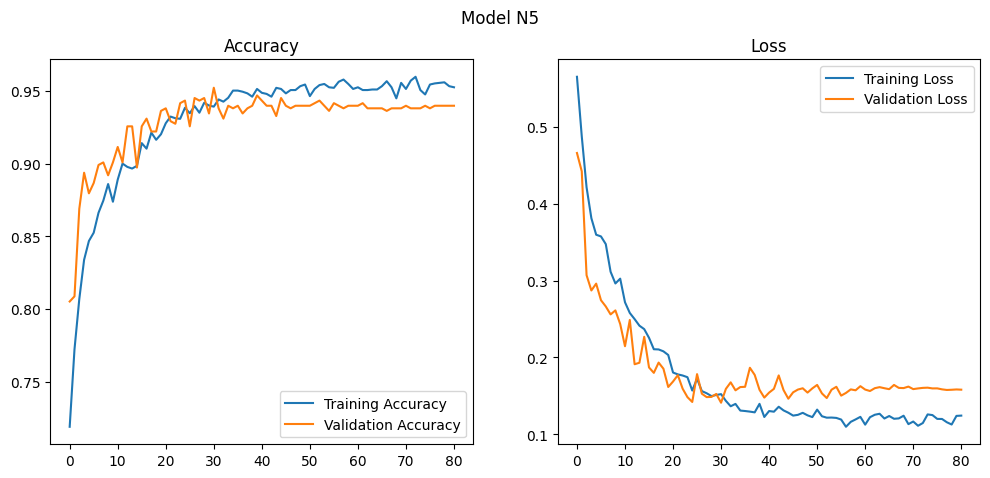

In [ ]:
plots_acc(history5, title='Model N5')

### SIXTH MODEL

In [ ]:

drive.mount('/content/drive')

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()


        self.data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomFlip('vertical'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])


        self.rescaling = layers.Rescaling(1./255, input_shape=(240, 240, 1))


        self.conv1 = layers.Conv2D(10, 3, padding='same', activation='relu')
        self.maxpool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(20, 3, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPooling2D()
        self.conv3 = layers.Conv2D(30, 3, padding='same', activation='relu')
        self.maxpool3 = layers.MaxPooling2D()


        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(40, activation='relu')
        self.dense2 = layers.Dense(20, activation='relu')
        self.dense3 = layers.Dense(10, activation='relu')


        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.data_augmentation(inputs, training=training)
        x = self.rescaling(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.output_layer(x)


model6 = MyModel()

model6.build(input_shape=(None, img_height, img_width, 1))


model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])


model6.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/MODELOSFINALES/MODELO4', save_best_only=True)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
learning_rate_scheduler = LearningRateScheduler(scheduler)

list_callbacks = [early_stopping, model_checkpoint, learning_rate_scheduler]



epochs = 120
history6 = model6.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=list_callbacks
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_7 (Rescaling)     multiple                  0         
                                                                 
 conv2d_25 (Conv2D)          multiple                  100       
                                                                 
 max_pooling2d_19 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          multiple                  1820      
                                                           

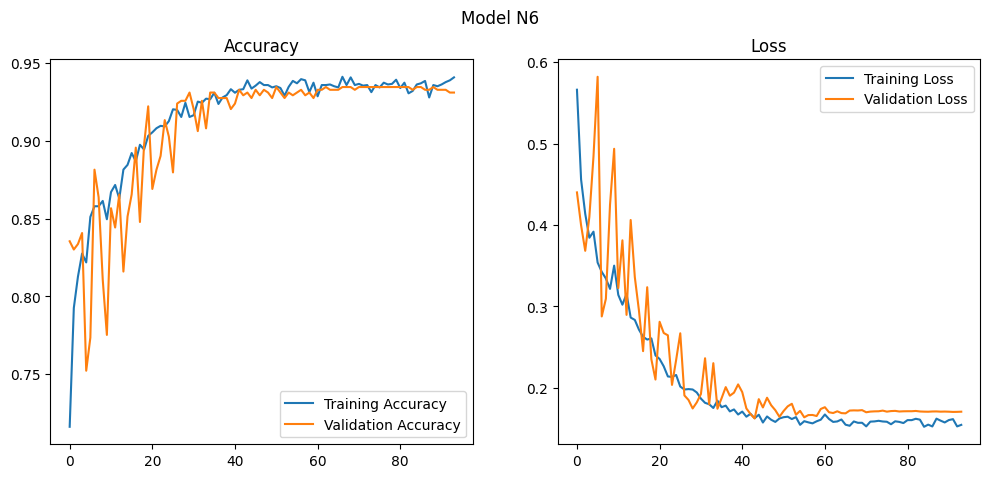

In [ ]:
plots_acc(history6, title='Model N6')

### SEVENTH MODEL

In [ ]:

class MyModel(Model):
    def __init__(self, neuroA, neuroB, neuroC, img_height, img_width, dropout_rate=0.3):
        super(MyModel, self).__init__()

        self.data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 1)),
            layers.RandomFlip('vertical'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])

        self.rescaling = layers.Rescaling(1./255)

        self.conv1 = layers.Conv2D(15, 3, padding='same', activation='relu')
        self.maxpool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(25, 3, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPooling2D()
        self.conv3 = layers.Conv2D(35, 3, padding='same', activation='relu')
        self.maxpool3 = layers.MaxPooling2D()

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(neuroA, activation='relu')
        self.dense2 = layers.Dense(neuroB, activation='relu')
        self.dense3 = layers.Dense(neuroC, activation='relu')

        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.data_augmentation(inputs, training=training)
        x = self.rescaling(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.output_layer(x)

# input imagen size and modal parameters
Input image size and model parameters
img_height = 240
img_width = 240
neuroA = 128
neuroB = 64
neuroC = 32


model7 = MyModel(neuroA, neuroB, neuroC, img_height, img_width)

model7.build(input_shape=(None, img_height, img_width, 1))


model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])


model7.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/MODELOSFINALES/MODELO5', save_best_only=True)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
learning_rate_scheduler = LearningRateScheduler(scheduler)

list_callbacks = [early_stopping, model_checkpoint, learning_rate_scheduler]


epochs = 120
history7 = model7.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=list_callbacks
)

Model: "my_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_8 (Rescaling)     multiple                  0         
                                                                 
 conv2d_28 (Conv2D)          multiple                  150       
                                                                 
 max_pooling2d_22 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          multiple                  3400      
                                                                 
 max_pooling2d_23 (MaxPooli  multiple                  0         
 ng2D)                                                  

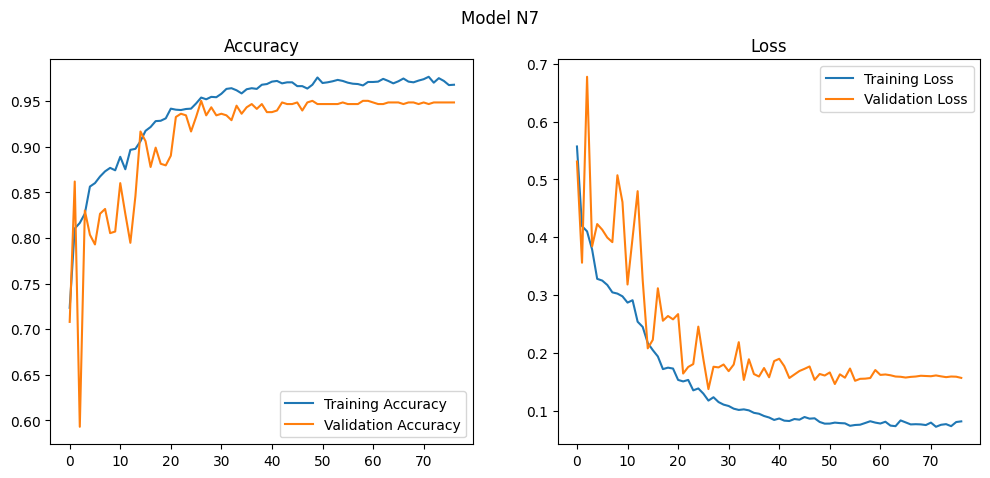

In [ ]:
plots_acc(history7, title='Model N7')

### EIGHTH MODEL - HYPERPARAMETERS

In [ ]:
class MyModel(Model):
    def __init__(self,neuroA,neuroB,neuroC,img_height, img_width, dropout_rate=0.3):
        super(MyModel, self).__init__()

        self.data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 1)),
            layers.RandomFlip('vertical', input_shape=(img_height, img_width, 1)),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])

        self.rescaling = layers.Rescaling(1./255, input_shape=(img_height, img_width, 1))

        self.conv1 = layers.Conv2D(15, 3, padding='same', activation='relu')
        self.maxpool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(25, 3, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPooling2D()
        self.conv3 = layers.Conv2D(35, 3, padding='same', activation='relu')
        self.maxpool3 = layers.MaxPooling2D()
        self.conv4 = layers.Conv2D(45, 3, padding='same', activation='relu')
        self.maxpool4 = layers.MaxPooling2D()

        self.flatten = layers.Flatten()

        self.dense1 = layers.Dense(130, activation='relu')
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dense2 = layers.Dense(20, activation='relu')
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dense3 = layers.Dense(10, activation='relu')
        self.dropout3 = layers.Dropout(dropout_rate)
        self.dense4 = layers.Dense(neuroA, activation='relu') #100
        self.dropout4 = layers.Dropout(dropout_rate)
        self.dense5 = layers.Dense(neuroB, activation='relu') #64
        self.dropout5 = layers.Dropout(dropout_rate)
        self.dense6 = layers.Dense(neuroC, activation='relu') #32
        self.dropout6 = layers.Dropout(dropout_rate)
        self.dense7 = layers.Dense(16, activation='relu')
        self.dropout7 = layers.Dropout(dropout_rate)

        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.data_augmentation(inputs, training=training)
        x = self.rescaling(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.maxpool4(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        x = self.dense3(x)
        x = self.dropout3(x, training=training)
        x = self.dense4(x)
        x = self.dropout4(x, training=training)
        x = self.dense5(x)
        x = self.dropout5(x, training=training)
        x = self.dense6(x)
        x = self.dropout6(x, training=training)
        x = self.dense7(x)
        x = self.dropout7(x, training=training)

        return self.output_layer(x)

img_height = 240
img_width = 240

In [ ]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, img_height, img_width):
        self.img_height = img_height
        self.img_width = img_width

    def build(self, hp):
        hp_unitsA = hp.Int('neuroA', min_value=60, max_value=90, step=2)
        hp_unitsB = hp.Int('neuroB', min_value=50, max_value=70, step=2)
        hp_unitsC = hp.Int('neuroC', min_value=40, max_value=50, step=2)

        model = MyModel(neuroA=hp_unitsA, neuroB=hp_unitsB, neuroC=hp_unitsC, img_height=self.img_height, img_width=self.img_width, dropout_rate=0.3)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        return model


In [ ]:

img_height = 240
img_width = 240

my_model2 = MyHyperModel(img_height, img_width)

tuner = kt.RandomSearch(
    my_model2,
    objective='val_accuracy',
    max_trials=4,
    directory='my_tuning_directori2',
    project_name='my_image_classification'
)


tuner.search(train_dataset, epochs=5, validation_data=val_dataset, batch_size=32)# Make sure that train_dataset and val_dataset are defined and are of the right type


In [ ]:

best_hps2 = tuner.get_best_hyperparameters(num_trials=1)[0]


print("Mejores hiperparámetros:") ## Print the best hyperparameters
for key, value in best_hps2.values.items():
    print(f"{key}: {value}")


best_model2 = my_model2.build(best_hps2)# Build the model with the best hyperparameters

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/MODELOSFINALES/MODELO8", save_weights_only=True, save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

def exponential_decay(epoch, lr):
  if epoch < 10:
    return lr
  else:
    decay_rate = 0.8
    decay_step = 20
    return lr * decay_rate ** (epoch/decay_step)

learning_scheduler_cb= tf.keras.callbacks.LearningRateScheduler(exponential_decay)


In [ ]:
Mejores hiperparámetros:
neuroA: 66
neuroB: 58
neuroC: 42
learning_rate: 0.001

In [ ]:

class MyModel(Model):
    def __init__(self,neuroA=66,neuroB=58,neuroC=42,img_height=240, img_width=240, dropout_rate=0.3):
        super(MyModel, self).__init__()

        self.data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 1)),
            layers.RandomFlip('vertical', input_shape=(img_height, img_width, 1)),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])

        self.rescaling = layers.Rescaling(1./255, input_shape=(img_height, img_width, 1))

        self.conv1 = layers.Conv2D(15, 3, padding='same', activation='relu')
        self.maxpool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(25, 3, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPooling2D()
        self.conv3 = layers.Conv2D(35, 3, padding='same', activation='relu')
        self.maxpool3 = layers.MaxPooling2D()
        self.conv4 = layers.Conv2D(45, 3, padding='same', activation='relu')
        self.maxpool4 = layers.MaxPooling2D()

        self.flatten = layers.Flatten() #array

        self.dense1 = layers.Dense(130, activation='relu')
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dense2 = layers.Dense(20, activation='relu')
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dense3 = layers.Dense(10, activation='relu')
        self.dropout3 = layers.Dropout(dropout_rate)
        self.dense4 = layers.Dense(neuroA, activation='relu') #100
        self.dropout4 = layers.Dropout(dropout_rate)
        self.dense5 = layers.Dense(neuroB, activation='relu') #64
        self.dropout5 = layers.Dropout(dropout_rate)
        self.dense6 = layers.Dense(neuroC, activation='relu') #32
        self.dropout6 = layers.Dropout(dropout_rate)
        self.dense7 = layers.Dense(16, activation='relu')
        self.dropout7 = layers.Dropout(dropout_rate)

        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.data_augmentation(inputs, training=training)
        x = self.rescaling(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.maxpool4(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)

        x = self.dense3(x)

        x = self.dense4(x)
        x = self.dropout4(x, training=training)
        x = self.dense5(x)
        x = self.dropout5(x, training=training)
        x = self.dense6(x)
        x = self.dropout6(x, training=training)
        x = self.dense7(x)


        return self.output_layer(x)


best_model2= MyModel()
best_model2.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/MODELOSFINALES/MODELO8", save_weights_only=True, save_best_only=True)


In [ ]:
history_fit = best_model2.fit(train_dataset,
                              epochs=100,
                              validation_data=val_dataset,
                              #batch_size=32,
                              callbacks=[checkpoint_cb]
                              )

Epoch 1/100
83/83 [==============================] - 8s 43ms/step - loss: 0.6611 - accuracy: 0.6474 - val_loss: 0.6113 - val_accuracy: 0.7204
Epoch 2/100
83/83 [==============================] - 3s 35ms/step - loss: 0.5318 - accuracy: 0.7652 - val_loss: 0.5706 - val_accuracy: 0.7735
Epoch 3/100
83/83 [==============================] - 3s 35ms/step - loss: 0.4802 - accuracy: 0.7952 - val_loss: 0.4559 - val_accuracy: 0.7929
Epoch 4/100
83/83 [==============================] - 3s 34ms/step - loss: 0.4595 - accuracy: 0.8078 - val_loss: 0.5493 - val_accuracy: 0.7115
Epoch 5/100
83/83 [==============================] - 3s 38ms/step - loss: 0.4261 - accuracy: 0.8176 - val_loss: 0.3651 - val_accuracy: 0.8301
Epoch 6/100
83/83 [==============================] - 3s 35ms/step - loss: 0.3881 - accuracy: 0.8378 - val_loss: 0.5501 - val_accuracy: 0.7027
Epoch 7/100
83/83 [==============================] - 3s 34ms/step - loss: 0.4023 - accuracy: 0.8283 - val_loss: 0.3711 - val_accuracy: 0.8584
Epoch 

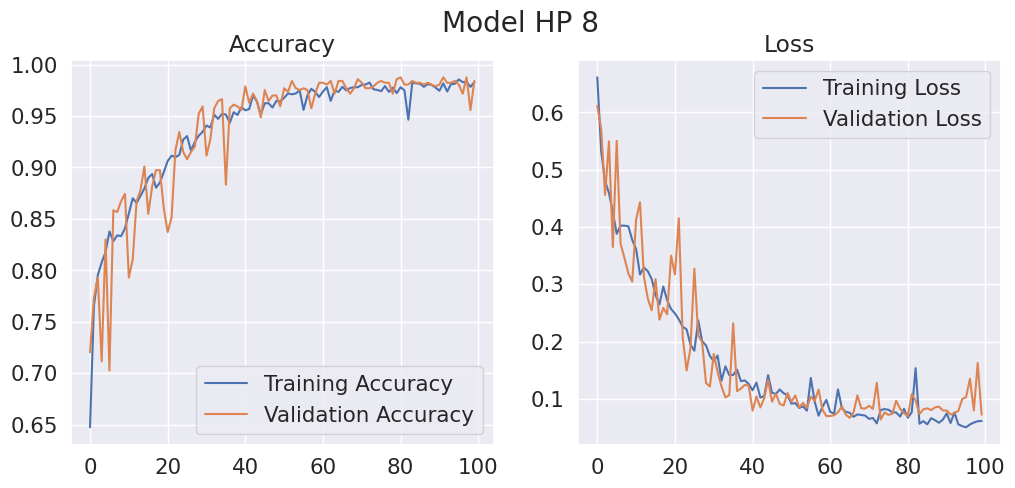

In [ ]:
plots_acc(history_fit, title='Model HP 8')

### METRICS

In [ ]:
class ModeloTF:
    def __init__(self, path_modelo):
        self.path_modelo = path_modelo
        self.modelo = self.cargar_modelo()

    def cargar_modelo(self):
        # Monta Google Drive para acceder a los archivos
        drive.mount('/content/drive')
        # Carga el modelo de TensorFlow/Keras desde el path especificado
        return tf.keras.models.load_model(self.path_modelo)

    def predecir(self, X_test):
        # Realiza predicciones con el modelo cargado
        # Asegúrate de que X_test esté preprocesado de la misma manera que los datos de entrenamiento
        predicciones = self.modelo.predict(X_test)
        # Convierte las predicciones a etiquetas de clase (p.ej., el índice del valor máximo para clasificación multiclase)
        y_pred = np.argmax(predicciones, axis=1)
        return y_pred

    def generar_matriz_confusion(self, y_test, y_pred):
        # Genera la matriz de confusión
        matriz = confusion_matrix(y_test, y_pred)
        self.mostrar_matriz_confusion(matriz)

    @staticmethod
    def mostrar_matriz_confusion(matriz):
        # Muestra la matriz de confusión
        plt.figure(figsize=(10,7))
        plt.imshow(matriz, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Matriz de Confusión')
        plt.colorbar()
        tick_marks = np.arange(len(matriz))
        plt.xticks(tick_marks, tick_marks)
        plt.yticks(tick_marks, tick_marks)

        # Etiquetas de los ejes
        plt.ylabel('Etiqueta real')
        plt.xlabel('Etiqueta predicha')
        plt.show()

# Suponiendo que ya tienes X_test y y_test preparados
# path_modelo = 'ruta/a/tu/modelo/tf/en/google/drive'  # Debes actualizar esta ruta
# modelo_tf = ModeloTF(path_modelo)
# y_pred = modelo_tf.predecir(X_test)
# modelo_tf.generar_matriz_confusion(y_test, y_pred)


In [ ]:
def conf_matrix(models: Union[Any, List[Any]], val_dataset: Optional[Any] = None, data: Optional[Tuple[np.ndarray, np.ndarray]] = None) -> None:
    if not isinstance(models, list):
        models = [models]

    for model in models:
        y_true: List[Union[int, float]] = []
        y_pred: List[Union[int, float]] = []

        if data is not None:
            if isinstance(data, tuple) and len(data) == 2:
                y_pred = model.predict(np.array(data[0]))
                y_true = np.array(data[1])
            else:
                raise ValueError("The 'data' parameter should be a tuple containing (x, y).")
        elif val_dataset is not None:
            for batch in val_dataset:
                x_val, labels = batch
                y_pred_batch = model.predict(x_val)
                y_true.extend(labels.numpy())
                y_pred.extend(y_pred_batch)
        else:
            raise ValueError("Either 'val_dataset' or 'data' must be provided.")

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        y_pred_label = (y_pred > 0.5).astype(int)

        conf_matrix_result = confusion_matrix(y_true, y_pred_label)

        # Visualization of the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.set(font_scale=1.4)  # Font size
        ax = sns.heatmap(conf_matrix_result, annot=True, cmap='Blues', fmt='g')

        # Titles and labels
        ax.set_title('Confusion Matrix\n')
        ax.set_xlabel('\nPredictions')
        ax.set_ylabel('True Values ')

        # Tick labels
        ax.xaxis.set_ticklabels(['No tumor', 'Tumor'])
        ax.yaxis.set_ticklabels(['No tumor', 'Tumor'])

        # Adjust tick visualization
        plt.yticks(rotation=90)

        plt.show()

In [ ]:
def roc_curves(models: Union[Any, List[Any]], val_dataset: Optional[Any] = None, data: Optional[Tuple[np.ndarray, np.ndarray]] = None) -> None:
    if not isinstance(models, list):
        models = [models]

    plt.figure(figsize=(10, 8))

    for model in models:
        y_true = []
        y_pred = []

        if data is not None:
            if isinstance(data, tuple) and len(data) == 2:# and isinstance(data[0], np.ndarray) and isinstance(data[1], np.ndarray):

                y_pred = model.predict(np.array(data[0]))
                y_true = np.array(data[1])
            else:
                raise ValueError("The 'data' parameter should be a tuple containing two numpy arrays (X, y).")
        elif val_dataset is not None:
            for x_val, labels in val_dataset:
                y_pred_batch = model.predict(x_val)
                y_true.extend(labels)  # Assuming labels is already a numpy array or a list
                y_pred.extend(y_pred_batch)
        else:
            raise ValueError("Either 'val_dataset' or 'data' must be provided.")

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)  # Calcula el AUC


        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (model {models.index(model)+1}, area = {roc_auc:.2f})')# Plots the ROC curve for the current model


    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOS/MODELO1')
model2 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOS/MODELO2')
model3 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOSFINALES/modelo3D_a.h5')
model4 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOSFINALES/MODELO3')
model5 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOSFINALES/MODELO 1')
model6 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOSFINALES/MODELO 4')
model7 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOSFINALES/MODELO 5')
model8 = tf.keras.models.load_model('/content/drive/MyDrive/MODELOSFINALES/MODELO8')

In [ ]:
listam=[model1,model2,model3,model4,model5,model6,model7,model8]

18/18 [==============================] - 0s 10ms/step


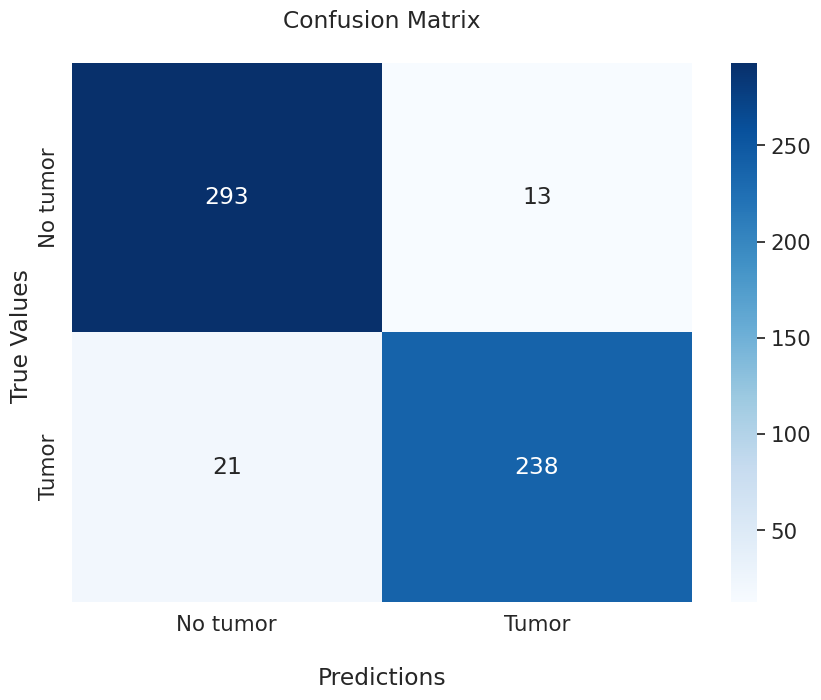

18/18 [==============================] - 0s 7ms/step


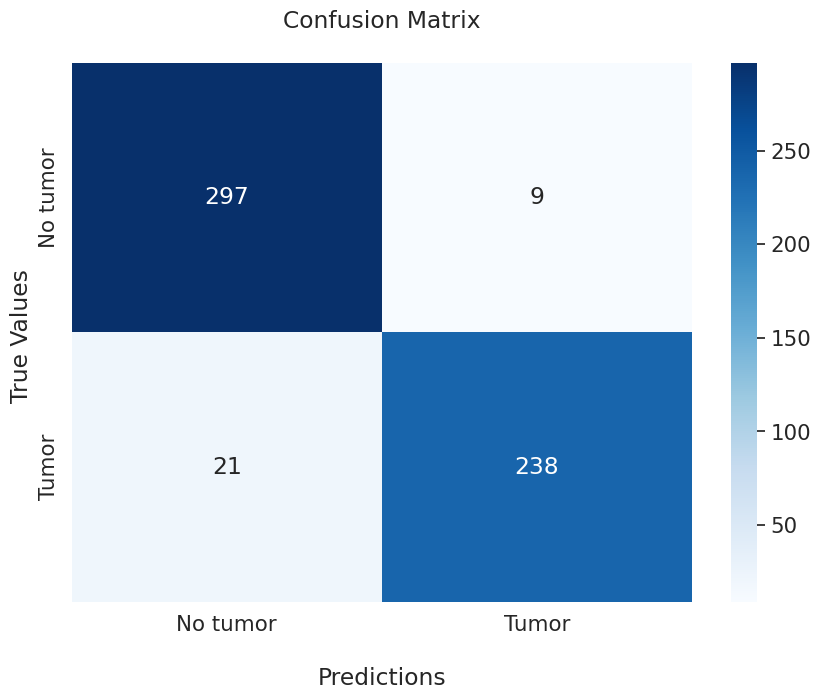

18/18 [==============================] - 0s 13ms/step


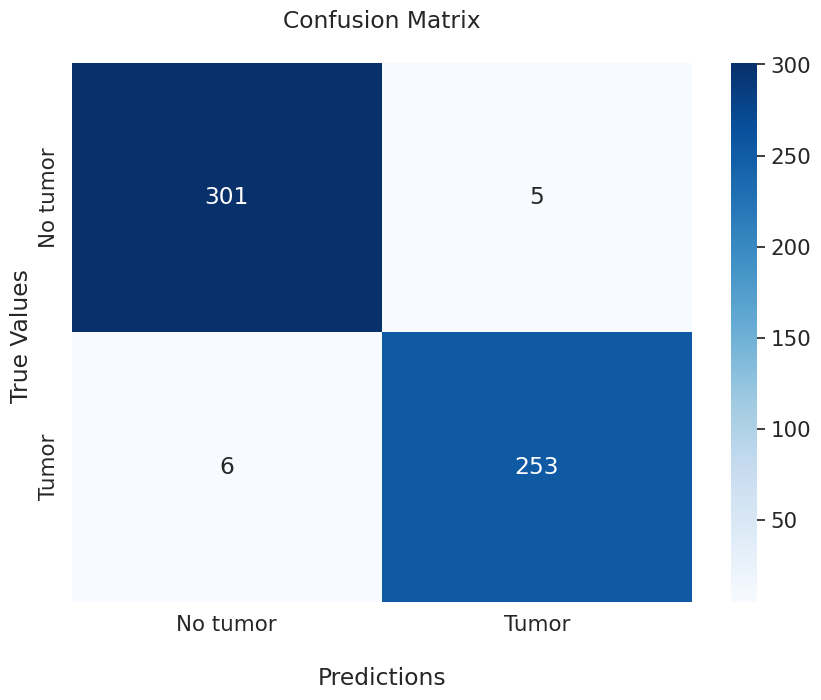

18/18 [==============================] - 0s 11ms/step


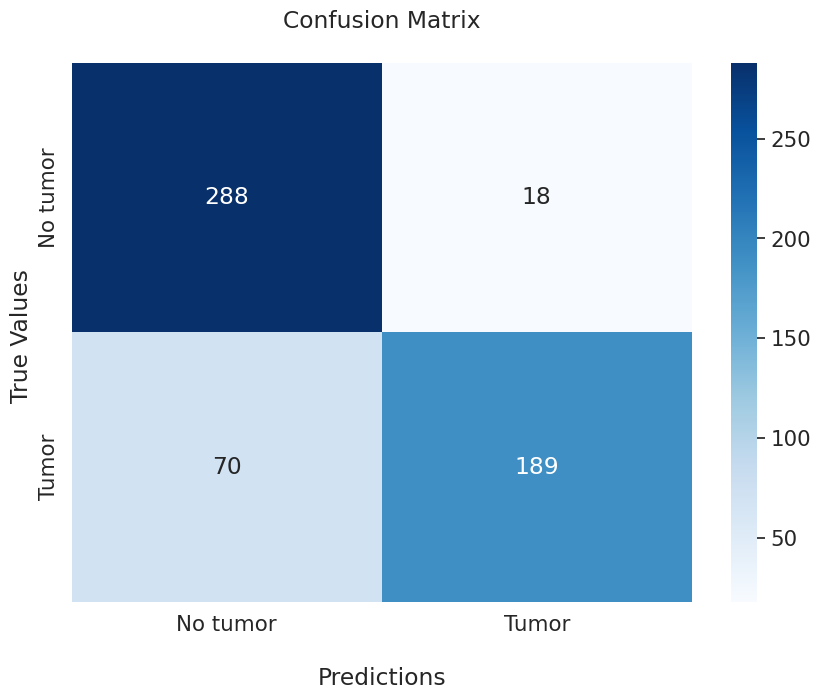

18/18 [==============================] - 0s 7ms/step


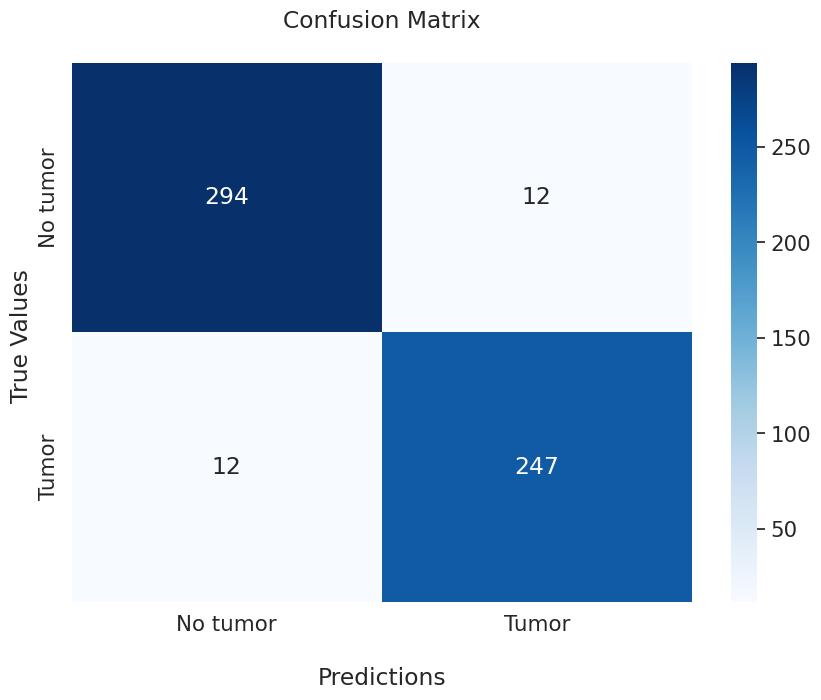

18/18 [==============================] - 0s 15ms/step


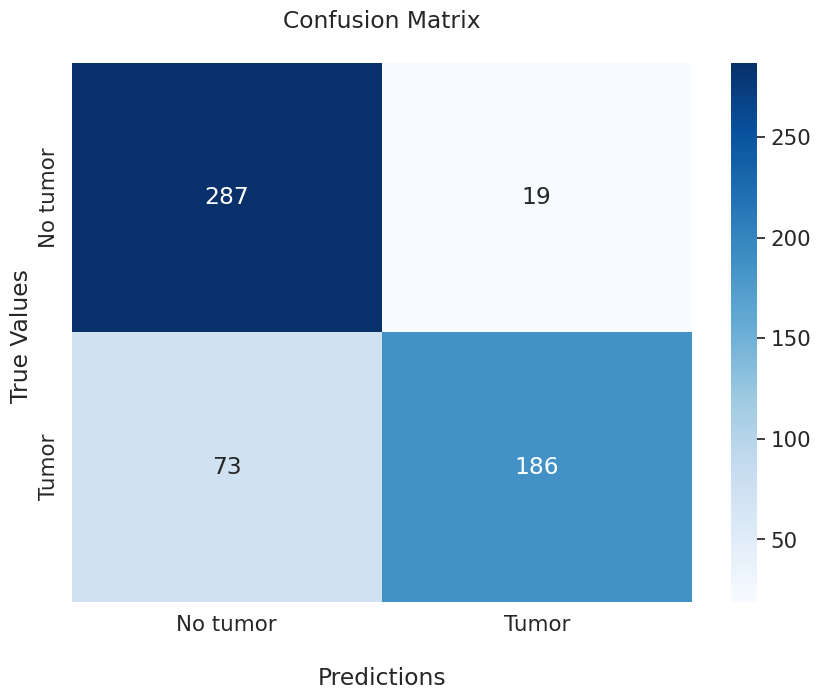

18/18 [==============================] - 0s 10ms/step


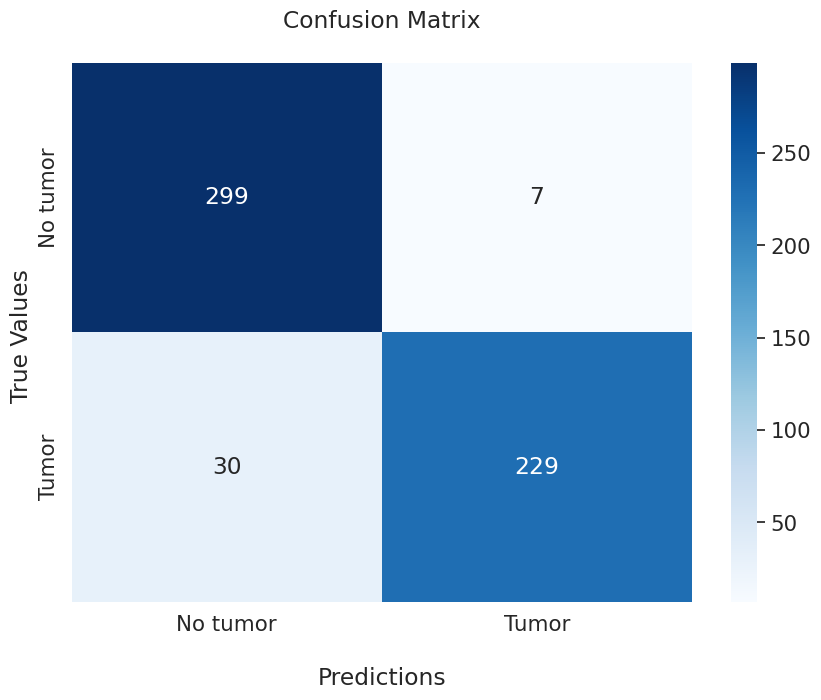

18/18 [==============================] - 0s 10ms/step


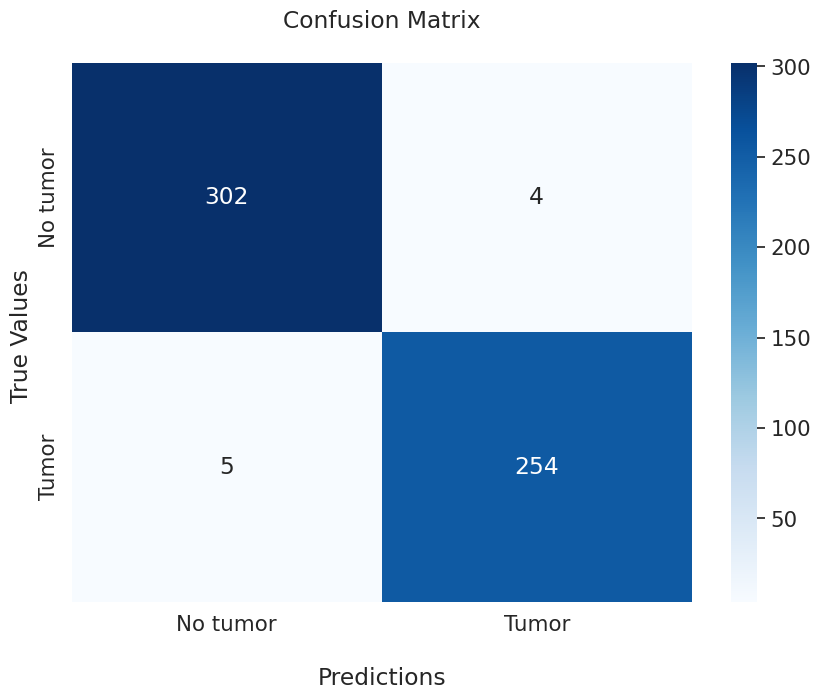

In [ ]:
conf_matrix(listam, data=(X_val,y_val))

18/18 [==============================] - 0s 10ms/step


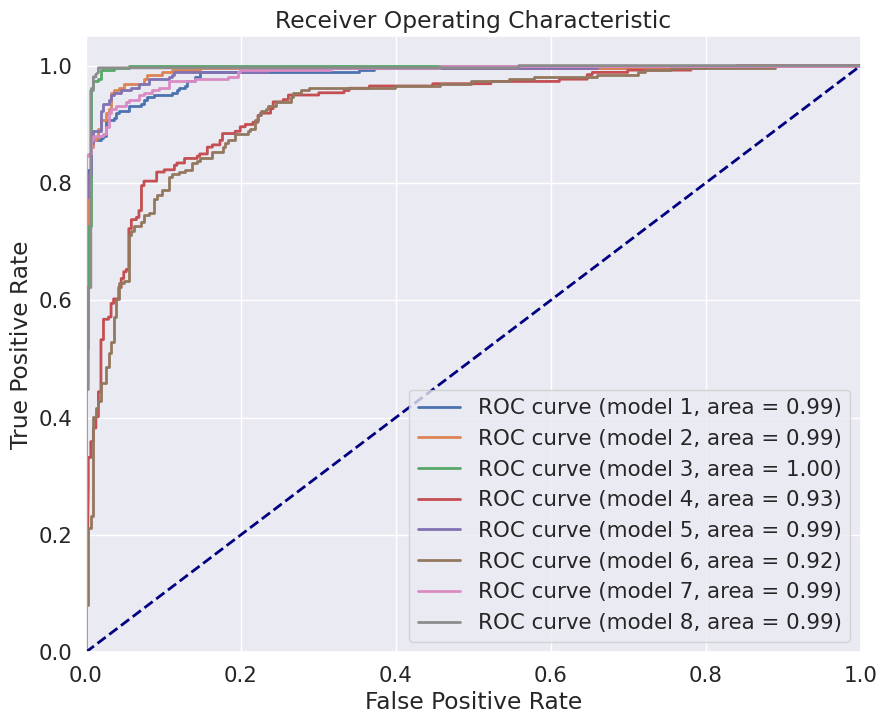

In [ ]:
roc_curves(listam,data=(X_val,y_val))

## Predictions Tumor-No Tumor

In [ ]:
class_names= ['No Tumor','Tumor']

In [ ]:
y_val

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,

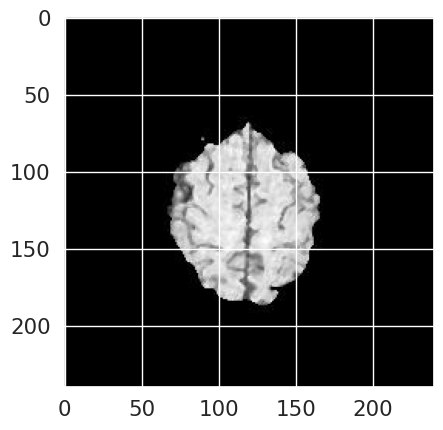

In [ ]:
plt.imshow(X_val[11], cmap='gray', vmax=255, vmin=0)
plt.show()

In [ ]:
def predict_img(modelo,img):
  img_array=tf.keras.utils.img_to_array(img)
  class_names= ['No Tumor','Tumor']
  img_array=tf.expand_dims(img_array,0)
  predictions = modelo.predict(img_array)
  score = tf.nn.sigmoid(predictions[0])
  A=np.round(predictions[0]).astype(int)
  print(
    'This image most likely belongs to {} with a {:.2f} percent confidence.'
    .format(class_names[A[0]],100*np.max(score))
    )




In [ ]:
dat = X_val[100]

In [ ]:
predict_img(model1,dat)

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to No Tumor with a 50.00 percent confidence.


In [ ]:
predict_img(model2,dat)

1/1 [==============================] - 0s 45ms/step
This image most likely belongs to No Tumor with a 50.00 percent confidence.


In [ ]:
predict_img(model3,dat)

1/1 [==============================] - 0s 47ms/step
This image most likely belongs to No Tumor with a 50.67 percent confidence.


In [ ]:
predict_img(model4,dat)

1/1 [==============================] - 0s 48ms/step
This image most likely belongs to No Tumor with a 50.78 percent confidence.


In [ ]:
predict_img(model5,dat)

1/1 [==============================] - 0s 47ms/step
This image most likely belongs to No Tumor with a 50.00 percent confidence.


In [ ]:
predict_img(model6,dat)

1/1 [==============================] - 0s 86ms/step
This image most likely belongs to No Tumor with a 50.63 percent confidence.


In [ ]:
predict_img(model7,dat)

1/1 [==============================] - 0s 60ms/step
This image most likely belongs to No Tumor with a 50.00 percent confidence.


In [ ]:
predict_img(model8,dat)

1/1 [==============================] - 0s 104ms/step
This image most likely belongs to No Tumor with a 50.01 percent confidence.
